High Value Customer Identification (Insiders)

# 0.0 Solution Planning (IOT)

## Input 
1. Business Issue
    - Select the most valuable customers for a loyalty program.
2. Dataset
    - E-commerce sels online, during one year period.

## Output
1. Recommendation list of customers the should be in Loyalty program.
- List: client_id | is_insider

2. Report with business answers:
- 1. Who are eligible to participate the Insiders Program?
- 2. How many customers will be part of the group?
- 3. What are the mainly characteristics of there customers?
- 4. What is the % of revenue coming of these customers?
- 5. What's the revenue expectation for this group next month?
- 6. What are the conditions for someone to be eligible for insiders?
- 7. What are the conditions for someone to be removed from insiders?
- 8. What is the guarantee that the Insiders program is best than the remaining base?
- 9. What actions the marketing team can do for increasing the revenue?

## Tasks

1. Report with business answers:
- 1. Who are eligible to participate the Insiders Program?
    - What is being eligible? What are the most valuable customers?
        - Cost:
        - Buy Experience
        - Basket Size
        - High buy likely
        - Low devolution rate.
- 2. How many customers will be part of the group?
    - Total number of customers
    - % of Insiders Group
- 3. What are the mainly characteristics of there customers?
    - Write customers characteristics:
        - Age
        - Localization
    - Write consuming characteristics:
        - Clustering Features

- 4. What is the % of revenue coming of these customers?
    - Total Revenue vs Insiders Group Revenue
- 5. What's the revenue expectation for this group next month?
    - Insiders Group LTV
    - Cohort Analysis 

- 6. What are the conditions for someone to be eligible for insiders?
    - Define the Insiders update periodicity  
    - The customers needs to be lookalike someone of the Insiders group.


- 7. What are the conditions for someone to be removed from insiders?
    - Define the Insiders update periodicity  
    - The customers needs to be unlookalike someone of the Insiders group.   


- 8. What is the guarantee that the Insiders program is best than the remaining base?
    - A/B test
    - A/B Bayesian test
    - Hypotesis Test


- 9. What actions the marketing team can do for increasing the revenue?
    - Discount
    - New products
    - New employees

## Solutions Benchmark
1. Desk Research

## 0.1 Import libraries

In [1]:

#adust md
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
import pandas as pd
import seaborn as sns
import numpy as np
import re, pickle
from pandas_profiling import ProfileReport
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn import cluster as c 
from sklearn import metrics as m
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.gridspec as gridspec
from plotly import express as px
import pylab 
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy as hc 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline


plt.rcParams["figure.figsize"] = (15,8)


## 0.2 Load dataset

In [2]:
df0 = pd.read_csv('data.csv', encoding='latin1')
df0.columns=df0.columns.str.lower()
df0.head(3)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


# 1.0 Data Description

In [3]:
df1=df0.copy()

## 1.1 data dimensions

In [4]:
df1.shape

(541909, 8)

## 1.2 N/As treatment

In [5]:
df1.isna().sum()/len(df1)

invoiceno      0.000000
stockcode      0.000000
description    0.002683
quantity       0.000000
invoicedate    0.000000
unitprice      0.000000
customerid     0.249267
country        0.000000
dtype: float64

In [6]:
df_missing=df1[df1['customerid'].isna()]
df_not_missing=df1[~df1['customerid'].isna()]
df_missing[df_missing['invoiceno'].isin(df_not_missing['invoiceno'])].shape

(0, 8)

In [7]:
# create reference
df_backup = pd.DataFrame( df_missing['invoiceno'].drop_duplicates())
df_backup['customerid']=np.arange(80000, 80000+len( df_backup ), 1)

# merge original with reference datafarme
df1 = df1.merge(df_backup, on='invoiceno', how='left')

#coalesce
df1['customerid']=df1['customerid_x'].combine_first( df1['customerid_y'])

#drop extra columns
df1 = df1.drop( columns=['customerid_x','customerid_y'], axis=1)

df1.isna().sum()

invoiceno         0
stockcode         0
description    1454
quantity          0
invoicedate       0
unitprice         0
country           0
customerid        0
dtype: int64

In [8]:
df1.isna().sum()

invoiceno         0
stockcode         0
description    1454
quantity          0
invoicedate       0
unitprice         0
country           0
customerid        0
dtype: int64

## 1.3 data types treatment

In [9]:
df1.dtypes

invoiceno       object
stockcode       object
description     object
quantity         int64
invoicedate     object
unitprice      float64
country         object
customerid     float64
dtype: object

In [10]:
df1.head(3)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,country,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,17850.0


In [11]:
df1['invoicedate']=df1['invoicedate'].str.split(expand=True)[0]
df1.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,country,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010,3.39,United Kingdom,17850.0


In [12]:
#invoice date
df1['invoicedate'] = pd.to_datetime( df1['invoicedate'], format="%m/%d/%Y",errors='coerce')

df1['customerid']=df1['customerid'].astype(int)
df1.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,country,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


## 1.4 descriptive statistics - numeric

In [13]:
num_attributes = df1.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [14]:
pd.concat([num_attributes.describe(percentiles=[.5]).T,num_attributes.agg(['skew','kurtosis']).T],axis=1)

,count,mean,std,min,50%,max,skew,kurtosis
quantity,541909.0,9.552250,218.081158,-80995.00,3.00,80995.0,-0.264076,119769.160031
unitprice,541909.0,4.611114,96.759853,-11062.06,2.08,38970.0,186.506972,59005.719097
customerid,541909.0,31894.123997,28863.991573,12346.00,16249.00,83709.0,1.151555,-0.657583


### 1.4.1 quantity

In [15]:
#how many negative quantities there is?

aux0=num_attributes[num_attributes['quantity']<0]
print(aux0['quantity'].head(3))
print(f"There is {len(aux0)/len(num_attributes)} negative quantity")
# Because it has less than  2% of negative quantity, in this Crisp-DM circle all negatives prices will be dropped


141    -1
154    -1
235   -12
Name: quantity, dtype: int64
There is 0.019604767590130447 negative quantity


### 1.4.2 unit price

In [16]:
# inspect unitprice equal zero
aux0=num_attributes[num_attributes['unitprice']==0]
print(aux0['unitprice'].head(3))
print(f"There is {len(aux0)/len(num_attributes)} 0 quantity")

# Because it has less than  1% of negative unit price, in this Crisp-DM circle all negatives prices will be dropped

622     0.0
1970    0.0
1971    0.0
Name: unitprice, dtype: float64
There is 0.004641000610803659 0 quantity


# 2.0 Feature Filtering/Cleaning

In [17]:
df2=df1.copy()

In [18]:
 # ----------------------  Numerical attributes ----------------
 # purhcases df and returns df
returns = df2.loc[df2['quantity'] < 0, :]
purchases = df2.loc[df2['quantity'] >= 0, :]


print(df2.shape)


#drop invoices with only letters
df2=df2[~df2['invoiceno'].str.contains('[^0-9]+', na=False)]
print(df2.shape)

#filter only stockcodes with numbers
#df2=df2[df2['stockcode'].str.contains('[0-9]+', na=False)]
print(df2.shape)


# ------------------ Categorical attributes -------------------
# drop description
df2 = df2.drop( columns='description', axis=1 )

# drop "unspecifiec" and "european communoty" countries -  
df2 = df2[~df2['country'].isin( ["European Community",'Unspecified' ] ) ]


# --------------------- Filter bad customer ----------------- (Section 5 Exploratory Data Analysis)
df2=df2[df2['customerid']!=16446]

df2.head()
print(df0.shape, df2.shape)

(541909, 8)
(532618, 8)
(532618, 8)
(541909, 8) (532109, 7)


# 3.0 Feature Engineering

In [19]:
# data reference
df3=df2.copy()

## 3.1 Feature Creation

In [20]:
df_ref=df3[['customerid']].drop_duplicates(ignore_index=True)
print(df_ref.shape)
df_ref.head(3)

(7853, 1)


,customerid
0,17850
1,13047
2,12583


### 3.1.1 profit (gross revenue - gross outgoings)

In [21]:
# gross revenue
purchases['gross_revenue'] = purchases['quantity'] * purchases['unitprice']
df_monetary = purchases[['customerid', 'gross_revenue']].groupby( 'customerid').sum().reset_index()
df_ref=df_ref.merge(df_monetary,on='customerid',how='left').fillna(0)
print(df_ref.isna().sum())


# gross outgoings
returns['gross_returns'] = returns['quantity'] * returns['unitprice']*-1
df_returns = returns[['customerid', 'gross_returns']].groupby( 'customerid').sum().reset_index()
df_ref=df_ref.merge(df_returns,on='customerid',how='left').fillna(0)
print(df_ref.isna().sum())


# df_ref.head()
# df_ref['profit'] = df_ref['gross_revenue']-df_ref['gross_returns']
# df_ref=df_ref.drop(['gross_revenue','gross_returns'], axis=1)
# df_ref.head()
print(df_ref.shape)

customerid       0
gross_revenue    0
dtype: int64
customerid       0
gross_revenue    0
gross_returns    0
dtype: int64
(7853, 3)


### 3.1.2 recency

In [22]:
#recency
df_recency = purchases.groupby(['customerid', 'invoicedate']).max().reset_index()
df_recency['recencydays'] = ( df2['invoicedate'].max() - df_recency['invoicedate'] ).dt.days
df_recency= df_recency[['customerid','recencydays']].copy()
df_ref=df_ref.merge(df_recency, how='left', on='customerid')

print(df_ref.isna().sum(), df_ref.shape)
df_ref.head()

customerid          0
gross_revenue       0
gross_returns       0
recencydays      1336
dtype: int64 (20273, 4)


,customerid,gross_revenue,gross_returns,recencydays
0,17850,5391.21,102.58,373.0
1,17850,5391.21,102.58,372.0
2,13047,3237.54,158.44,373.0
3,13047,3237.54,158.44,309.0
4,13047,3237.54,158.44,254.0


In [23]:
df_ref[df_ref['recencydays'].isnull()].head()

,customerid,gross_revenue,gross_returns,recencydays
1164,80013,0.0,0.0,NaN
1667,80019,0.0,0.0,NaN
2446,80036,0.0,0.0,NaN
2447,80037,0.0,0.0,NaN
2448,80038,0.0,0.0,NaN


### 3.1.3 quantity of items kept

In [24]:
# quantity of products purchased
df_freq = purchases[['customerid', 'quantity']].drop_duplicates().groupby( 'customerid' ).sum().reset_index().rename( columns={'quantity':'qtd_items'})
df_ref = pd.merge( df_ref, df_freq, on='customerid', how='left' ).fillna(0)
print(df_ref.isna().sum())

df_ref.head()


customerid       0
gross_revenue    0
gross_returns    0
recencydays      0
qtd_items        0
dtype: int64


,customerid,gross_revenue,gross_returns,recencydays,qtd_items
0,17850,5391.21,102.58,373.0,35.0
1,17850,5391.21,102.58,372.0,35.0
2,13047,3237.54,158.44,373.0,132.0
3,13047,3237.54,158.44,309.0,132.0
4,13047,3237.54,158.44,254.0,132.0


In [25]:
### quantity of items returned
# quantity of products purchased
df_freq = returns[['customerid', 'quantity']].drop_duplicates().groupby( 'customerid' ).sum().reset_index().rename( columns={'quantity':'qtd_items_return'})
df_freq['qtd_items_return'] = df_freq['qtd_items_return']*-1
df_ref = pd.merge( df_ref, df_freq, on='customerid', how='left' ).fillna(0)
df_ref.isna().sum()
print(df_ref.isna().sum())
df_ref.head()

customerid          0
gross_revenue       0
gross_returns       0
recencydays         0
qtd_items           0
qtd_items_return    0
dtype: int64


,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return
0,17850,5391.21,102.58,373.0,35.0,21.0
1,17850,5391.21,102.58,372.0,35.0,21.0
2,13047,3237.54,158.44,373.0,132.0,6.0
3,13047,3237.54,158.44,309.0,132.0,6.0
4,13047,3237.54,158.44,254.0,132.0,6.0


### 3.1.4 avg ticket

In [26]:
 # Avg Ticket
#df_ref['avg_ticket']=df_ref['profit']/(df_ref['qtd_items']-df_ref['qtd_items_return'])
df_ref['avg_ticket']=df_ref['gross_revenue']/(df_ref['qtd_items']-df_ref['qtd_items_return'])
df_ref['avg_ticket']=df_ref['avg_ticket'].replace([np.inf, -np.inf], 0) 
df_ref.isna().sum()

customerid          0
gross_revenue       0
gross_returns       0
recencydays         0
qtd_items           0
qtd_items_return    0
avg_ticket          0
dtype: int64

### 3.1.5 frequency

In [27]:
# frequency

df_aux = ( df2[['customerid', 'invoiceno', 'invoicedate']].drop_duplicates()
                                                        .groupby('customerid')
                                                        .agg( max_ = ('invoicedate', 'max'),
                                                            min_= ('invoicedate', 'min'),
                                                            days_= ('invoicedate', lambda x: (( x.max() - x.min()).days ) +1 ),
                                                            buy_ = ('invoiceno', 'count')).reset_index()
)

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_ref= df_ref.merge(df_aux[['customerid','frequency']], on='customerid', how='left')

df_ref.isna().sum()

customerid          0
gross_revenue       0
gross_returns       0
recencydays         0
qtd_items           0
qtd_items_return    0
avg_ticket          0
frequency           0
dtype: int64

### 3.1.6 basket size

In [28]:
df_aux = ( purchases.loc[:, ['customerid', 'invoiceno', 'quantity']].groupby( 'customerid' )
                                                                            .agg( n_purchase=( 'invoiceno', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customerid', 'avg_basket_size']], how='left', on='customerid' )
df_ref.isna().sum()

customerid             0
gross_revenue          0
gross_returns          0
recencydays            0
qtd_items              0
qtd_items_return       0
avg_ticket             0
frequency              0
avg_basket_size     1336
dtype: int64

### 3.1.7 nunique items

In [29]:
# basket size
df_aux = ( purchases.groupby('customerid').agg( n_purchases_unique = ('invoiceno','nunique'), n_products = ('quantity','sum'))
                                            .reset_index()
)

#calculation
df_ref = df_ref.merge( df_aux[['customerid', 'n_purchases_unique']], how='left', on='customerid')

print(df_ref.isna().sum())

df_ref.head()

customerid               0
gross_revenue            0
gross_returns            0
recencydays              0
qtd_items                0
qtd_items_return         0
avg_ticket               0
frequency                0
avg_basket_size       1336
n_purchases_unique    1336
dtype: int64


,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique
0,17850,5391.21,102.58,373.0,35.0,21.0,385.086429,17.000000,50.970588,34.0
1,17850,5391.21,102.58,372.0,35.0,21.0,385.086429,17.000000,50.970588,34.0
2,13047,3237.54,158.44,373.0,132.0,6.0,25.694762,0.029155,139.100000,10.0
3,13047,3237.54,158.44,309.0,132.0,6.0,25.694762,0.029155,139.100000,10.0
4,13047,3237.54,158.44,254.0,132.0,6.0,25.694762,0.029155,139.100000,10.0


### 3.1.8 profit and returns

# 4.0 Feature Selection

In [30]:
df4=df_ref.copy()
#cols=['customerid', 'gross_revenue', 'recencydays', 'qtd_items','qtd_items_return' , 'avg_ticket', 'frequency', 'avg_basket_size', "gross_returns"]
#print(df_ref.shape, df4.shape)
#df4=df4[cols]

# 5.0 EDA (Exploratory Data Analysis)

In [31]:
df5=df4.copy()
df5.head()

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique
0,17850,5391.21,102.58,373.0,35.0,21.0,385.086429,17.000000,50.970588,34.0
1,17850,5391.21,102.58,372.0,35.0,21.0,385.086429,17.000000,50.970588,34.0
2,13047,3237.54,158.44,373.0,132.0,6.0,25.694762,0.029155,139.100000,10.0
3,13047,3237.54,158.44,309.0,132.0,6.0,25.694762,0.029155,139.100000,10.0
4,13047,3237.54,158.44,254.0,132.0,6.0,25.694762,0.029155,139.100000,10.0


## 5.1 Univariate Analysis

In [32]:
num_attributes1 = df5.select_dtypes(include=['int64','float64','int32'])

In [33]:
a0=pd.concat([num_attributes1.describe(percentiles=[.5,.75]).T,num_attributes1.agg(['skew','kurtosis']).T],axis=1)
a0['max-0.75']=a0['max']-a0['75%']
a0['CV']=a0['std']/a0['mean']
a0

# NEGATIVE Tickets
# EXTREME Gross Revenue Value
# EXTREME qtd items values
# EXTREME qtd items return values
# EXTREME average ticket value and HIGH CV


,count,mean,std,min,50%,75%,max,skew,kurtosis,max-0.75,CV
customerid,20273.0,26830.486065,25275.405056,12346.000000,15856.000000,17739.000000,83709.00,1.709262,0.950578,65970.000000,0.942041
gross_revenue,20273.0,7426.024702,23899.678845,0.000000,1676.060000,4521.490000,280206.02,7.283891,64.756852,275684.530000,3.218368
gross_returns,20273.0,324.249572,1863.190664,0.000000,0.000000,60.900000,77183.60,13.638428,285.189413,77122.700000,5.746162
recencydays,20273.0,153.049425,116.293353,0.000000,141.000000,252.000000,373.00,0.307716,-1.179466,121.000000,0.759842
qtd_items,20273.0,723.356188,2411.931451,0.000000,186.000000,434.000000,74215.00,9.537386,138.696827,73781.000000,3.334362
qtd_items_return,20273.0,88.584521,687.583630,0.000000,1.000000,18.000000,74215.00,65.285264,6700.825306,74197.000000,7.761894
avg_ticket,20273.0,13.833867,110.320048,-282.937143,8.681333,15.892157,13541.33,97.042938,11336.296651,13525.437843,7.974636
frequency,20273.0,0.301628,0.455979,0.005450,0.050000,1.000000,17.00,5.840418,177.154735,16.000000,1.511724
avg_basket_size,18937.0,258.093850,654.922288,1.000000,172.444444,288.000000,74215.00,78.171952,8618.867613,73927.000000,2.537535
n_purchases_unique,18937.0,14.081428,28.217538,1.000000,6.000000,13.000000,210.00,4.819178,26.941588,197.000000,2.003883


### inspect EXTREME qtd items

In [34]:
df5.sort_values('qtd_items', ascending=False).head()

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique
8781,12346,77183.60,77183.60,325.0,74215.0,74215.0,0.000000,1.000000,74215.000000,1.0
3866,17450,194550.79,7068.62,199.0,38639.0,955.0,5.162689,0.127778,1521.586957,46.0
3875,17450,194550.79,7068.62,95.0,38639.0,955.0,5.162689,0.127778,1521.586957,46.0
3867,17450,194550.79,7068.62,197.0,38639.0,955.0,5.162689,0.127778,1521.586957,46.0
3868,17450,194550.79,7068.62,192.0,38639.0,955.0,5.162689,0.127778,1521.586957,46.0


In [35]:
df1[df1['customerid']==16446].head(10)
#this customer will be filtered out because it has a very extreme item buy quantity and extreme item devolutions

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,country,customerid
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09,2.08,United Kingdom,16446


### inspect EXTREME gross revenue values

In [36]:
df5.sort_values('gross_revenue', ascending=False).head()

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique
7275,14646,280206.02,717.0,23.0,15853.0,628.0,18.404336,0.20904,2668.797297,74.0
7236,14646,280206.02,717.0,354.0,15853.0,628.0,18.404336,0.20904,2668.797297,74.0
7238,14646,280206.02,717.0,329.0,15853.0,628.0,18.404336,0.20904,2668.797297,74.0
7239,14646,280206.02,717.0,324.0,15853.0,628.0,18.404336,0.20904,2668.797297,74.0
7240,14646,280206.02,717.0,323.0,15853.0,628.0,18.404336,0.20904,2668.797297,74.0


In [37]:
#inspect higher profit customer
df1[df1['customerid']==18102].head(10)
# This customer just buys a lot :)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,country,customerid
16425,537657,82484,WOOD BLACK BOARD ANT WHITE FINISH,408,2010-12-07,4.78,United Kingdom,18102
16426,537657,22830,UTILTY CABINET WITH HOOKS,30,2010-12-07,19.84,United Kingdom,18102
16427,537657,22189,CREAM HEART CARD HOLDER,972,2010-12-07,2.31,United Kingdom,18102
16428,537657,22188,BLACK HEART CARD HOLDER,972,2010-12-07,2.31,United Kingdom,18102
16429,537657,21623,VINTAGE UNION JACK MEMOBOARD,408,2010-12-07,6.38,United Kingdom,18102
16430,537658,82484,WOOD BLACK BOARD ANT WHITE FINISH,48,2010-12-07,4.78,United Kingdom,18102
16431,537658,22189,CREAM HEART CARD HOLDER,36,2010-12-07,2.31,United Kingdom,18102
16432,537658,22188,BLACK HEART CARD HOLDER,36,2010-12-07,2.31,United Kingdom,18102
16433,537659,22765,NEWSPAPER STAND,23,2010-12-07,9.89,United Kingdom,18102
16434,537659,22507,MEMO BOARD RETROSPOT DESIGN,208,2010-12-07,3.86,United Kingdom,18102


### Inspect extreme qtd items return values


In [38]:
df5.sort_values('qtd_items_return', ascending=False).head()

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique
8781,12346,77183.60,77183.60,325.0,74215.0,74215.0,0.000000,1.000000,74215.000000,1.0
15913,81915,0.00,0.00,0.0,0.0,9600.0,-0.000000,1.000000,NaN,NaN
15912,81914,0.00,0.00,0.0,0.0,9600.0,-0.000000,1.000000,NaN,NaN
3977,15838,33643.08,292.32,121.0,6474.0,9361.0,-11.653301,0.053221,966.736842,19.0
3982,15838,33643.08,292.32,11.0,6474.0,9361.0,-11.653301,0.053221,966.736842,19.0


In [39]:
df1[df1['customerid']==16029] 
# This one just returns a lot

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,country,customerid
175,536386,84880,WHITE WIRE EGG HOLDER,36,2010-12-01,4.95,United Kingdom,16029
176,536386,85099C,JUMBO BAG BAROQUE BLACK WHITE,100,2010-12-01,1.65,United Kingdom,16029
177,536386,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01,1.65,United Kingdom,16029
178,536387,79321,CHILLI LIGHTS,192,2010-12-01,3.82,United Kingdom,16029
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,2010-12-01,3.37,United Kingdom,16029
...,...,...,...,...,...,...,...,...
431946,573774,22666,RECIPE BOX PANTRY YELLOW DESIGN,36,2011-11-01,2.55,United Kingdom,16029
431947,573774,23206,LUNCH BAG APPLE DESIGN,50,2011-11-01,1.45,United Kingdom,16029
431948,573774,22961,JAM MAKING SET PRINTED,96,2011-11-01,1.25,United Kingdom,16029
431949,573774,21931,JUMBO STORAGE BAG SUKI,100,2011-11-01,1.74,United Kingdom,16029


In [40]:
# These customers have only returns. It's not coherent to compare them with the others. This database didn't capture their previous purchase,
#therefore it's impossible to find out if the customers generate profit for the company (Bought more than delivered).

## Avg Ticket

In [41]:
df5.sort_values('avg_ticket',ascending=True)

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique
10110,13725,1980.56,170.75,305.0,130.0,137.0,-282.937143,0.030769,100.75,8.0
10116,13725,1980.56,170.75,49.0,130.0,137.0,-282.937143,0.030769,100.75,8.0
10111,13725,1980.56,170.75,292.0,130.0,137.0,-282.937143,0.030769,100.75,8.0
10115,13725,1980.56,170.75,169.0,130.0,137.0,-282.937143,0.030769,100.75,8.0
10109,13725,1980.56,170.75,308.0,130.0,137.0,-282.937143,0.030769,100.75,8.0
...,...,...,...,...,...,...,...,...,...,...
12117,80863,2583.76,0.00,269.0,1.0,0.0,2583.760000,1.000000,1.00,1.0
18091,82759,2653.95,0.00,81.0,1.0,0.0,2653.950000,1.000000,1.00,1.0
16089,81972,3133.12,0.00,172.0,1.0,0.0,3133.120000,1.000000,2.00,1.0
16741,82245,4287.63,0.00,144.0,1.0,0.0,4287.630000,1.000000,1.00,1.0


In [42]:
df0[df0['customerid']==13725]['unitprice'].describe()

count    118.000000
mean       4.199576
std        3.940500
min        0.190000
25%        1.460000
50%        2.950000
75%        4.950000
max       16.950000
Name: unitprice, dtype: float64

In [43]:
df5[df5['avg_ticket']<0].shape[0]

48

In [44]:
# The database don't contains all purchases of these customers, therefore It will be filtered out.
# Note: The objective of this project is to select the most valuable customers to be in a fidelity program. We cannot take the risk of having a customer that return more than purchases.

In [45]:
df5['avg_ticket'].isnull().sum()

0

In [46]:
# The customers delivered the same amount that purchased, therefore the profit is 0 and the avg_profit_ticket must be zero.

## 4.2 Filters Applied

In [47]:
#bad customer
print(df5.shape)
df5=df5[df5['customerid']!=16446]
df5=df5[df5['customerid']!=14646]
#df5=df5[df5['avg_basket_size'].notnull()]
df5=df5[df5['avg_ticket']>0]
df5['avg_ticket']=df5['avg_ticket'].fillna(0)
print(df5.shape)

(20273, 10)
(18059, 10)


# 6.0 Data Preparation

In [48]:
df6=df5.copy()

In [49]:
df6.columns

Index(['customerid', 'gross_revenue', 'gross_returns', 'recencydays',
       'qtd_items', 'qtd_items_return', 'avg_ticket', 'frequency',
       'avg_basket_size', 'n_purchases_unique'],
      dtype='object')

## 6.1 Check Normality

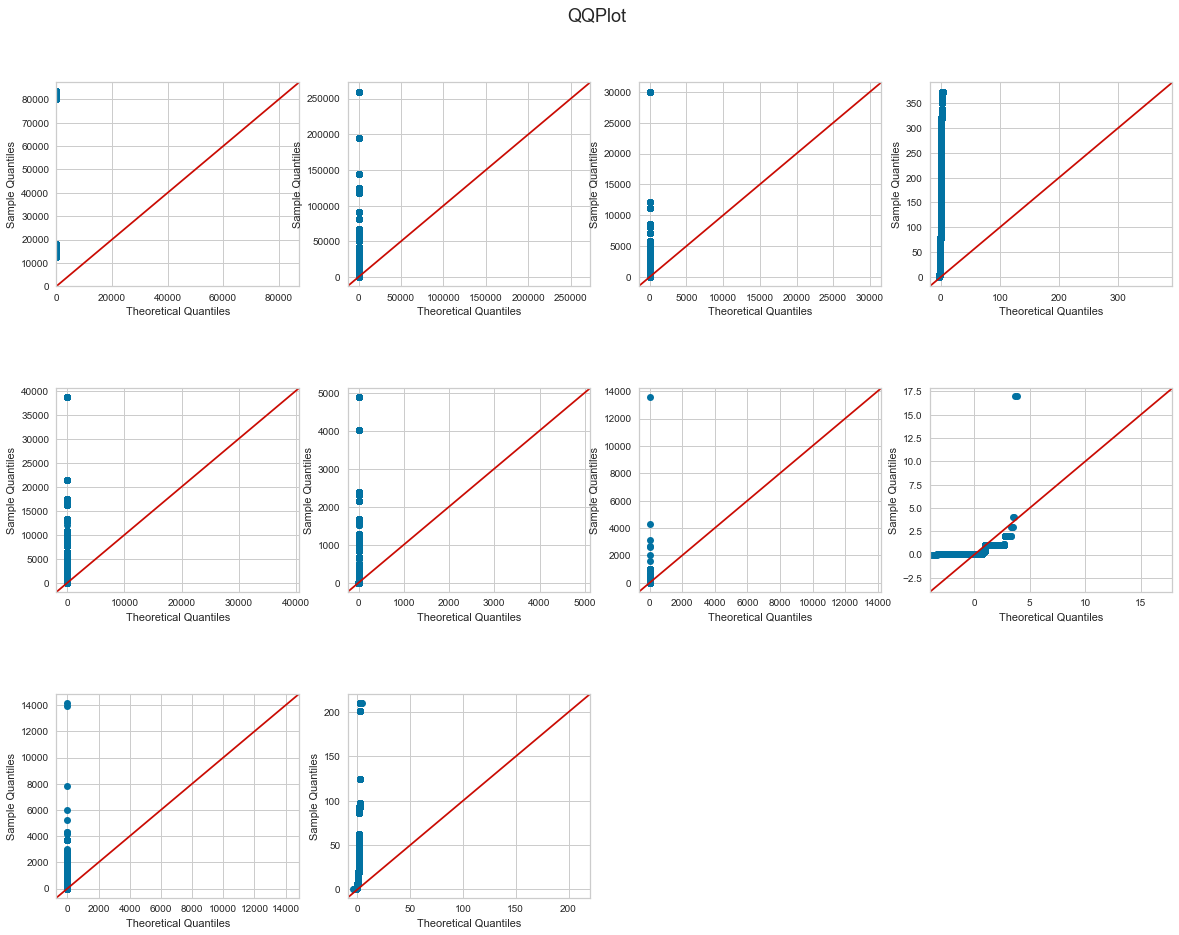

In [50]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("QQPlot", fontsize=18, y=0.95)

tickers = df5.select_dtypes(exclude='object').columns


# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(3, 4, n + 1)

    # filter df and plot ticker on the new subplot axis

    measurements=df6[ticker]
    sm.qqplot(measurements, line='45', ax=ax)
    #pylab.show()

    # chart formatting
    #ax.set_title(ticker.upper())
    #ax.get_legend().remove()
    #ax.set_xlabel("")

## 6.2 Check Outliers

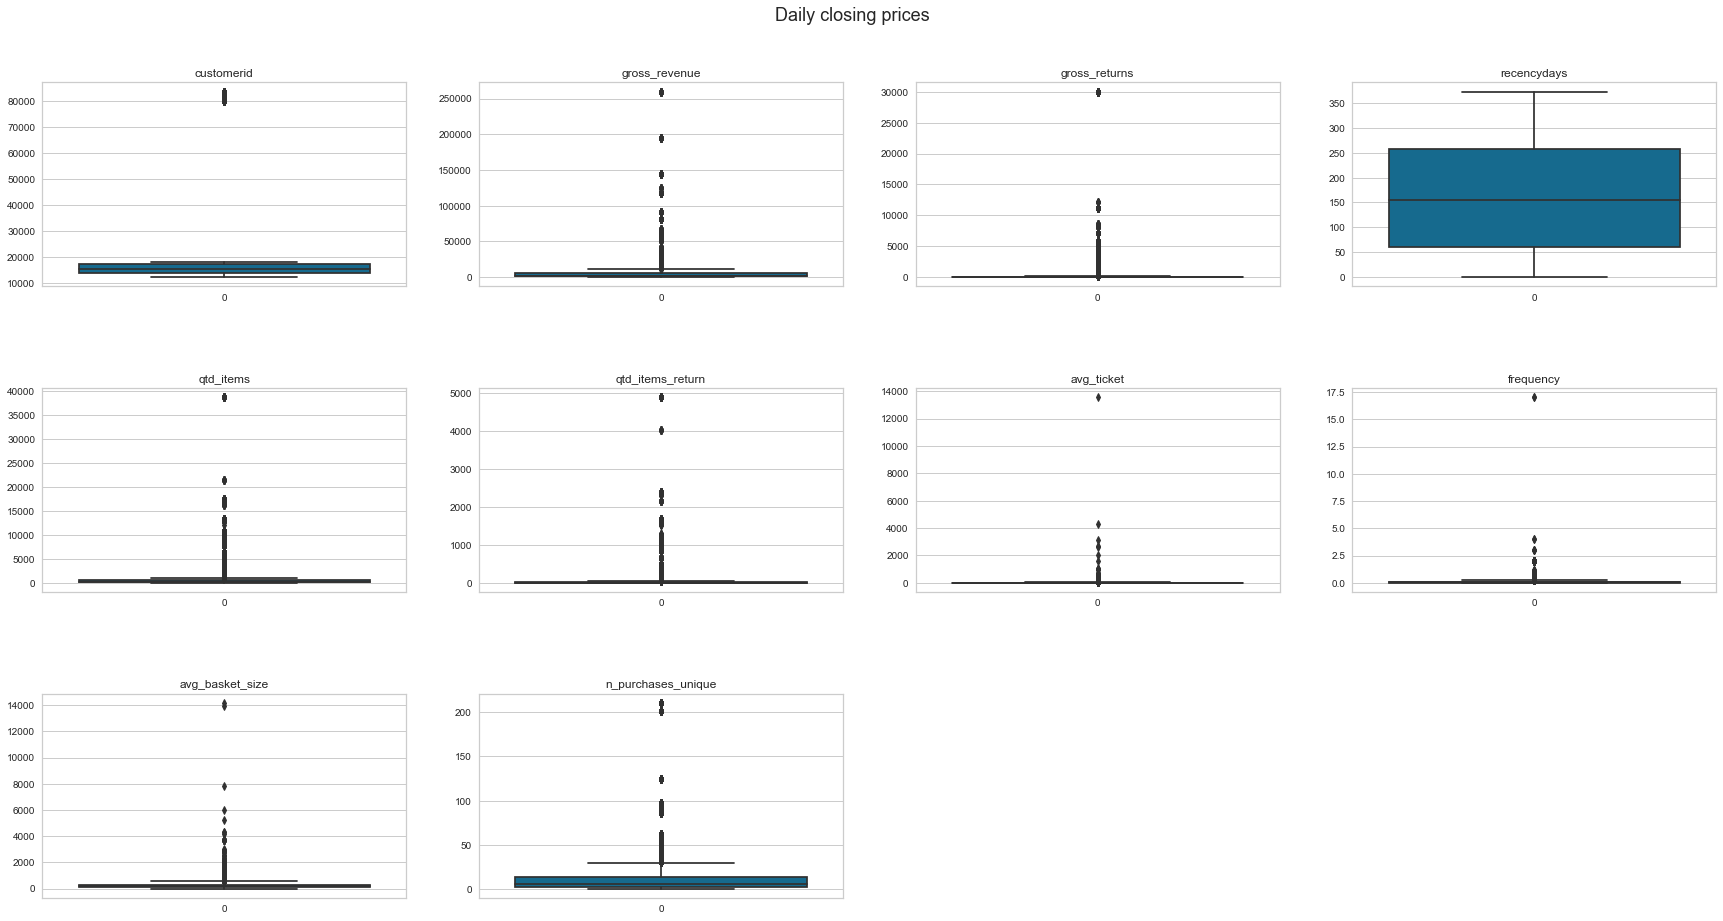

In [51]:
plt.figure(figsize=(30, 15));
plt.subplots_adjust(hspace=0.5);
plt.suptitle("Daily closing prices", fontsize=18, y=0.95);

tickers = df5.select_dtypes(exclude='object').columns;


# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(3, 4, n + 1)

    sns.boxplot(data=df6[ticker])

    ax.set_title(ticker)


In [52]:
from sklearn.preprocessing import KBinsDiscretizer

In [53]:
mms=MinMaxScaler()
ss=StandardScaler()
rs=RobustScaler()
kb=KBinsDiscretizer(n_bins=4,  encode='ordinal', strategy='quantile')


mms_cols=[ 'recencydays',
        'avg_ticket', 'frequency',
       'avg_basket_size', 'n_purchases_unique']

rs_cols=['gross_revenue', 'gross_returns', 
       'qtd_items', 'qtd_items_return',]
# rs_cols=[ 'gross_revenue','qtd_items',
#        'qtd_items_return', 'avg_ticket', 'frequency', 'avg_basket_size',
#        'gross_returns','n_purchases_unique']

for i in mms_cols:
     df6[[i]] = mms.fit_transform(df6[[i]])
     pickle.dump(mms, open(f"artifacts/{i}_minmax.pickle",'wb'))


for i in rs_cols:
     df6[[i]] = kb.fit_transform(df6[[i]])
     pickle.dump(kb, open(f"artifacts/{i}_robust.pickle",'wb'))


df6.head()

p:\Anaconda3\envs\automl\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique
0,17850,3.0,2.0,1.000000,0.0,2.0,0.028434,1.000000,0.003532,0.157895
1,17850,3.0,2.0,0.997319,0.0,2.0,0.028434,1.000000,0.003532,0.157895
2,13047,2.0,2.0,1.000000,1.0,1.0,0.001893,0.001395,0.009761,0.043062
3,13047,2.0,2.0,0.828418,1.0,1.0,0.001893,0.001395,0.009761,0.043062
4,13047,2.0,2.0,0.680965,1.0,1.0,0.001893,0.001395,0.009761,0.043062


# 7.0 Hyperparameter Tuning

In [54]:
df7=df6.copy()
X=df7.drop(columns=['customerid'])
clusters= [2, 3, 4, 5, 6]

In [55]:
X.head(1)

,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique
0,3.0,2.0,1.0,0.0,2.0,0.028434,1.0,0.003532,0.157895


## 7.1 KMeans


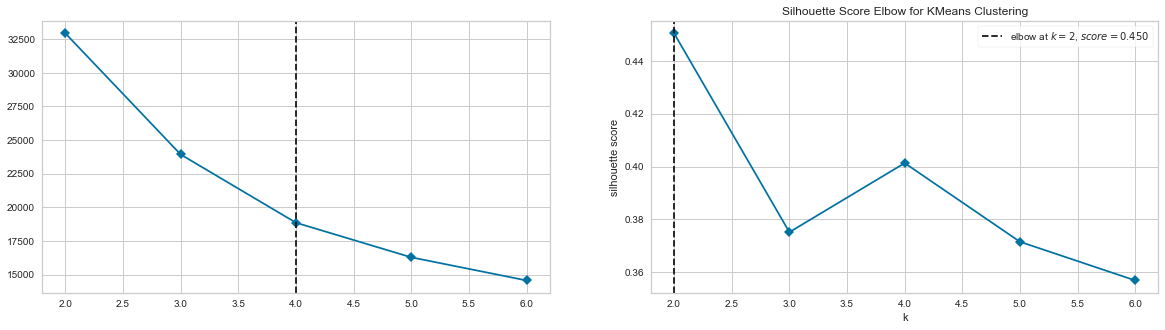

In [56]:
plt.subplot(1,2,1)
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False, metric='distortion')
kmeans.fit(X)


plt.subplot(1,2,2)
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False, metric='silhouette')
kmeans.fit(X)
plt.gcf().set_size_inches(20,5)
kmeans.finalize()

In [57]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k, init="k-means++" )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

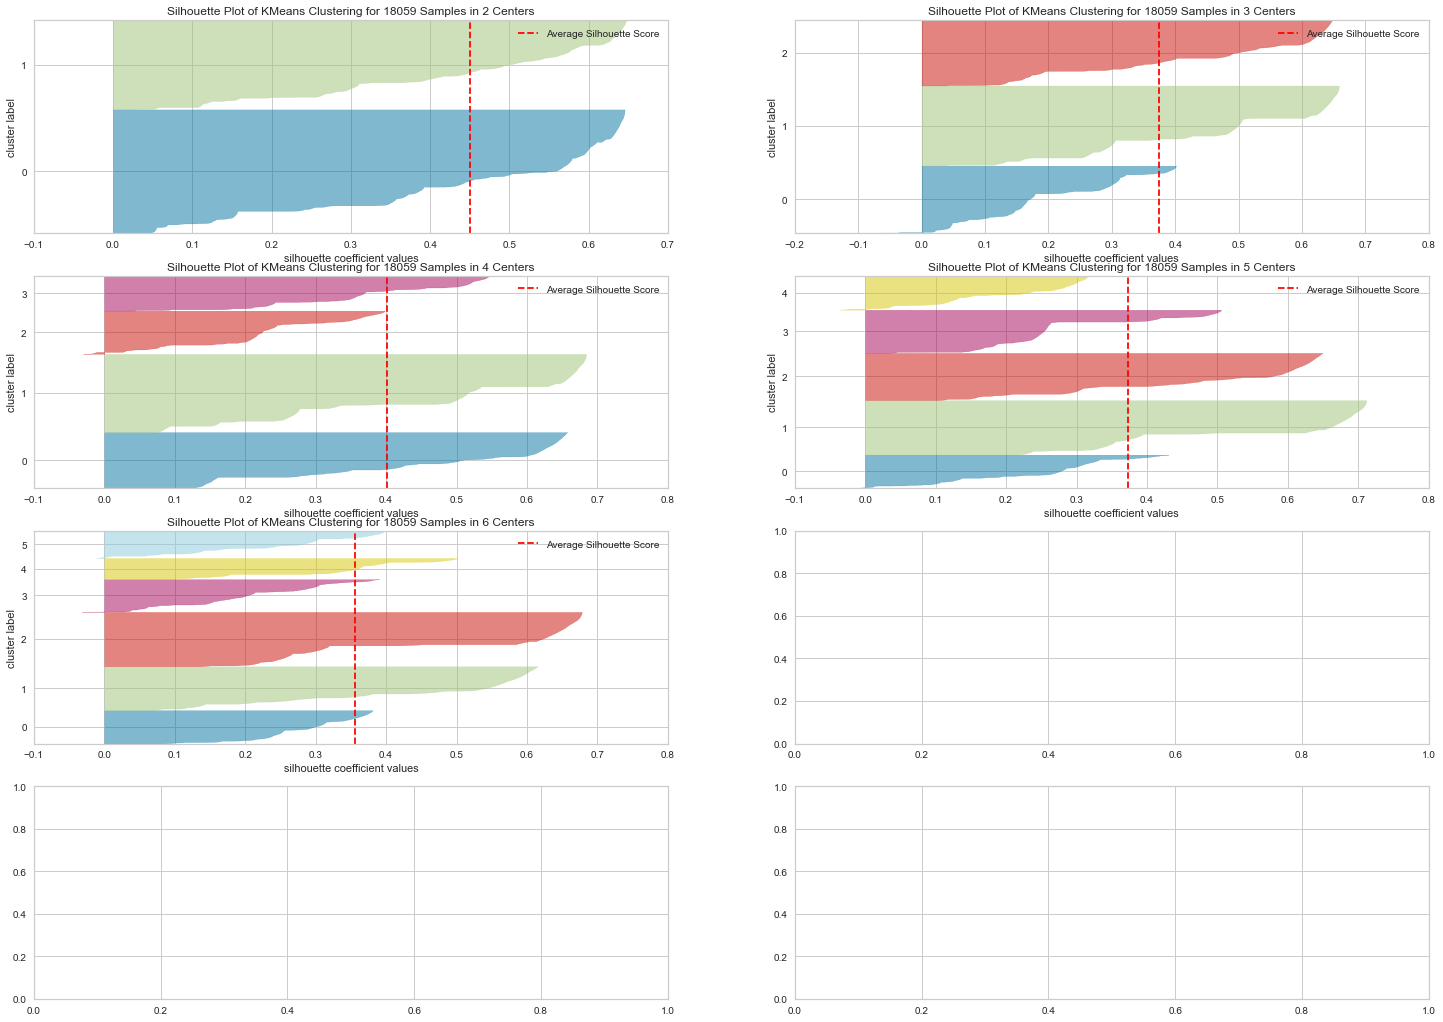

In [58]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette.fit(X)
    vis_silhouette.finalize()

## 7.2 GMM

In [59]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

Text(0.5, 1.0, 'Sil x K')

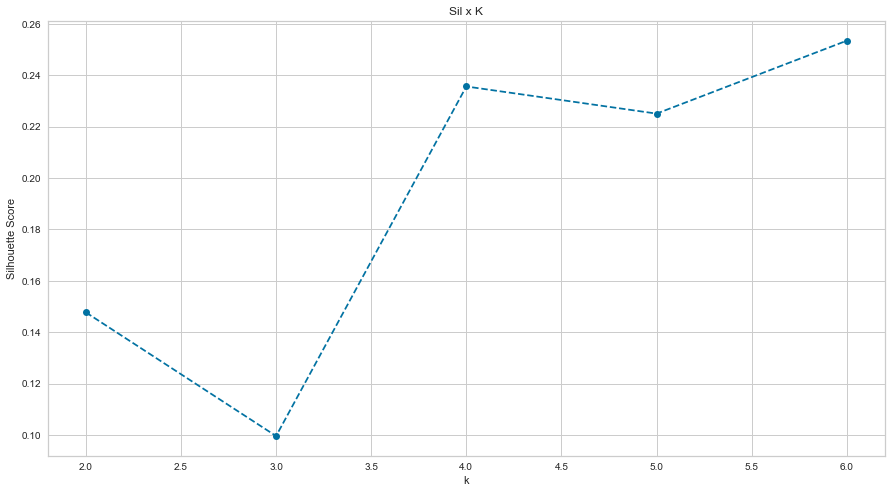

In [60]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k')
plt.ylabel( 'Silhouette Score')
plt.title( 'Sil x K')

## 7.3 Hierarchical Clustering

[]

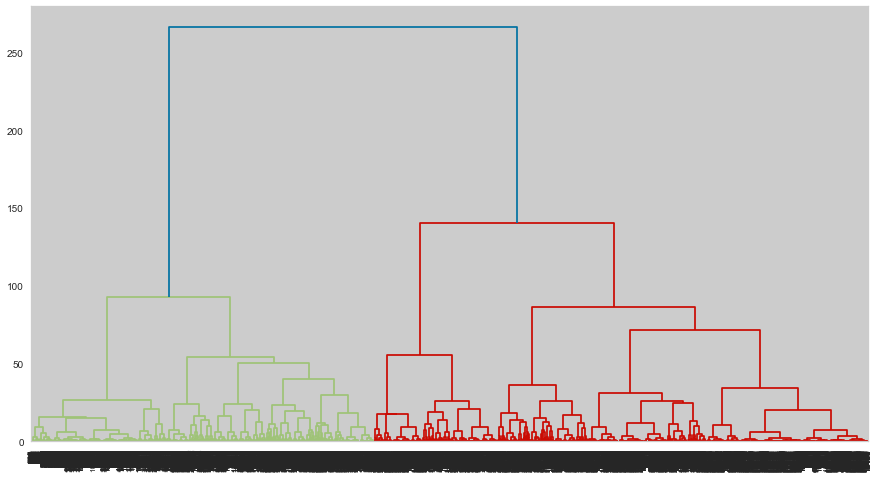

In [61]:
hc_model = hc.linkage( X, 'ward' )
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)
plt.plot()

In [62]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

In [ ]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

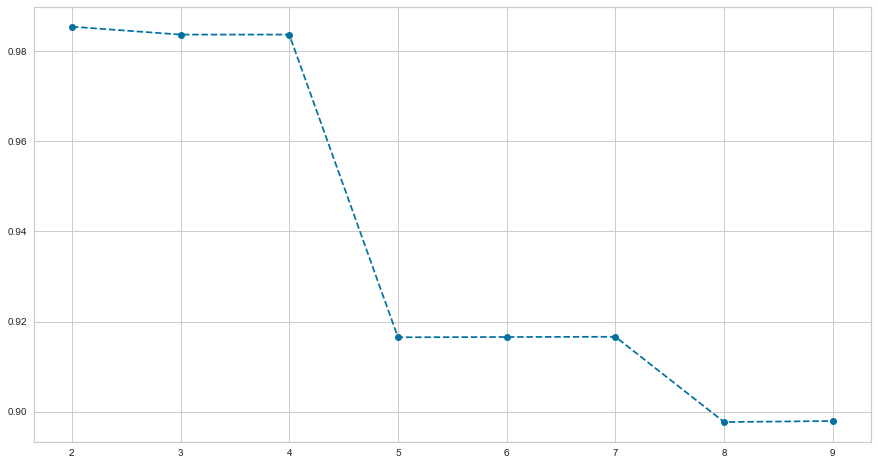

In [ ]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' ) 

## 7.4 DBScan

In [ ]:
eps=[.1, .2, .3, .4, .5, .6, .7]


for i in eps:
# model definition
    dbscan_model = c.DBSCAN( eps=i )

    # mode training & predict 
    labels = dbscan_model.fit_predict( X )

    sil = m.silhouette_score( X, labels, metric='euclidean' )
    print( 'Silhouette Score: {}'.format( sil ) )
    print( 'Number of Clusters: {}'.format( len( np.unique( labels ) ) ) )
    print( np.unique( labels ) )

Silhouette Score: 0.5035766525263866
Number of Clusters: 2
[-1  0]
Silhouette Score: 0.6587438667201112
Number of Clusters: 2
[-1  0]
Silhouette Score: 0.7318984612771768
Number of Clusters: 2
[-1  0]
Silhouette Score: 0.7411970555091357
Number of Clusters: 2
[-1  0]
Silhouette Score: 0.7467365538051673
Number of Clusters: 2
[-1  0]
Silhouette Score: 0.7482350912896476
Number of Clusters: 2
[-1  0]
Silhouette Score: 0.762823033128013
Number of Clusters: 2
[-1  0]


In [ ]:
eps=.7
for i in np.arange(1,30,5):
    # model definition
    dbscan_model = c.DBSCAN( eps=eps, min_samples=i )

    # mode training & predict 
    labels = dbscan_model.fit_predict( X )

    sil = m.silhouette_score( X, labels, metric='euclidean' )
    print( f'Silhouette Score {sil} , min_samples = {i}' )

Silhouette Score 0.7025853009907341 , min_samples = 1
Silhouette Score 0.762823033128013 , min_samples = 6
Silhouette Score 0.762823033128013 , min_samples = 11
Silhouette Score 0.762823033128013 , min_samples = 16
Silhouette Score 0.762823033128013 , min_samples = 21
Silhouette Score 0.762823033128013 , min_samples = 26


In [ ]:
# model definition
dbscan_model = c.DBSCAN( eps=0.7, min_samples=26 )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( f'Silhouette Score {sil}')

Silhouette Score 0.762823033128013


In [ ]:
dbscan_list = [ .70, .76, .76, .76, .76, ] 

## 7.5 Results

In [ ]:
gmm_list

[0.020003543979281616,
 -0.13043756493935807,
 0.08746371292201133,
 0.05568194661796501,
 0.058394731575282716]

In [ ]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     #'HC': hc_list, 
     'DBSCAN': dbscan_list
   }
).T

df_results.columns = clusters

In [ ]:
df_results.style.highlight_max( color='green', axis=1 ) 


,2,3,4,5,6
KMeans,0.671320,0.602642,0.494945,0.477037,0.490577
GMM,0.020004,-0.130438,0.087464,0.055682,0.058395
DBSCAN,0.700000,0.760000,0.760000,0.760000,0.760000


# 8.0  Model Training

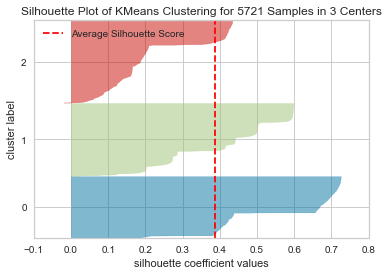

In [ ]:
km = c.KMeans(n_clusters=3, init="k-means++", n_init=15, max_iter=100, random_state=42)
vis_silhouette = SilhouetteVisualizer(km, colors='yellowbrick')
vis_silhouette.fit(X)
vis_silhouette.finalize()

In [ ]:
df8=df5.copy()
df8['cluster']=km.labels_
df8.groupby('cluster').mean().style.highlight_max( color='green', axis=0)

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique,profit,items_kept
cluster,,,,,,,,,,,,
0,20211.924628,2412.096654,57.619208,16.698992,275.542487,14.971195,11.104459,0.254663,248.456652,5.758041,2354.477446,260.571291
1,44779.077760,606.446330,8.386703,265.783826,88.435459,2.105754,15.821542,0.907625,181.288258,1.197512,598.059627,86.329705
2,25796.145423,1084.180156,34.351506,64.824636,189.253208,3.961506,13.376161,0.511132,256.704539,2.437126,1049.828650,185.291702
3,45026.932283,615.404836,8.451071,193.823622,98.211024,1.513386,16.208012,0.774898,170.545857,1.483465,606.953765,96.697638
4,49947.716446,918.886144,5.607164,342.922495,94.149338,1.172023,38.880347,0.988667,246.459459,1.164461,913.278979,92.977316
5,39922.535322,932.766452,10.969733,130.472527,159.145997,2.139717,23.984370,0.652623,253.142902,1.902669,921.796719,157.006279
6,20925.160000,73338.191200,3837.012800,8.760000,10636.560000,940.360000,12.443618,0.234970,2105.271755,56.240000,69501.178400,9696.200000


In [ ]:
df8['cluster'].value_counts(normalize=True)
## The Insiders (cluster 1) cluster has a lot of customers, considering a real world situation, it is not good to the marketing team afford so many customers.
# Let's create the features "profit" and "items kept" to see if it help to separate more the cluster 1.

0    0.364097
2    0.204335
1    0.112393
5    0.111344
3    0.110995
4    0.092466
6    0.004370
Name: cluster, dtype: float64

In [ ]:
df8['cluster'].value_counts()


0    2083
2    1169
1     643
5     637
3     635
4     529
6      25
Name: cluster, dtype: int64

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

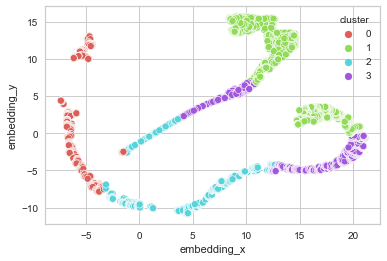

In [ ]:
reducer = umap.UMAP(n_neighbors=40, random_state=42)

a0=df7.drop(['customerid'],axis=1).copy()

embedding = reducer.fit_transform( a0 )



# embedding
a0['embedding_x']=embedding[:,0]
a0['embedding_y']=embedding[:,1]
a0['cluster']=df8['cluster']

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors= len(a0['cluster'].unique())),
                data=a0)

In [ ]:
# training dataset

a1 = df7.drop(['gross_revenue','customerid'],axis=1)
y = df7['gross_revenue']


# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state=42)

# model training

rf_model.fit( a1, y )

#leaf 

df_leaf = pd.DataFrame(rf_model.apply(a1))
a1.head(2)

,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique
0,0.003416,0.997319,0.00088,0.004309,0.028434,1.000000,0.003532,0.157895
1,0.005276,0.083110,0.00339,0.001231,0.001893,0.001395,0.009761,0.043062


p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

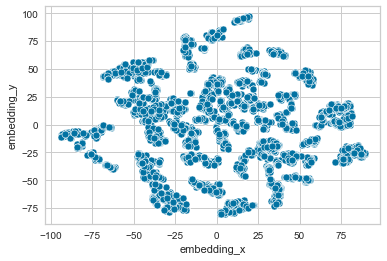

In [ ]:
reducer = TSNE( random_state=42)
embedding = reducer.fit_transform( df_leaf )

# embedding
df_leaf['embedding_x']=embedding[:,0]
df_leaf['embedding_y']=embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=df_leaf)

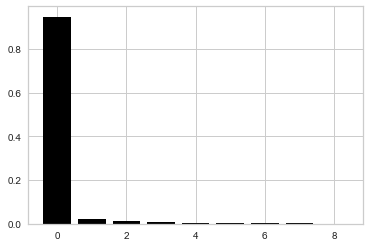

In [ ]:

pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color='black')

df_pca=pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

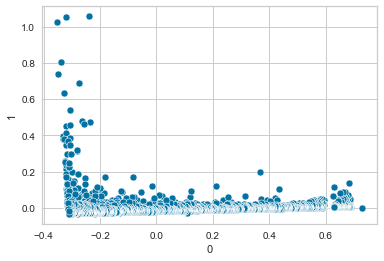

In [ ]:
sns.scatterplot(x=0 , y=1, data=df_pca)

p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

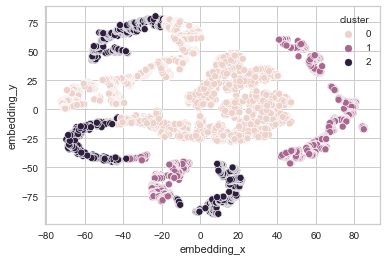

In [ ]:
reducer = TSNE( random_state=42)
embedding = reducer.fit_transform( X )

# embedding
X['embedding_x']=embedding[:,0]
X['embedding_y']=embedding[:,1]
X['cluster']=df7['cluster']

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y', hue='cluster',
                data=X)

In [ ]:
X.head()

## This CLusterization didn't separate well the customers

In [ ]:
# training dataset

a1 = df7.drop(['gross_revenue','customerid','cluster'],axis=1)
y = df7['gross_revenue']


# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state=42)

# model training

rf_model.fit( a1, y )

#leaf 

df_leaf = pd.DataFrame(rf_model.apply(a1))
a1.head(2)

,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,gross_returns,embedding_x,embedding_y
0,0.997319,-0.371257,21.0,40.502289,16.413793,1.262198,24.42381,1.725259,10.879515
1,0.083110,0.209581,6.0,1.980876,-0.995954,0.046709,37.72381,1.723873,11.828541


p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

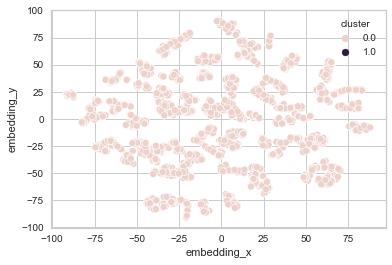

In [ ]:
reducer = TSNE( random_state=42)
embedding = reducer.fit_transform( df_leaf )

# embedding
df_leaf['embedding_x']=embedding[:,0]
df_leaf['embedding_y']=embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=df_leaf)

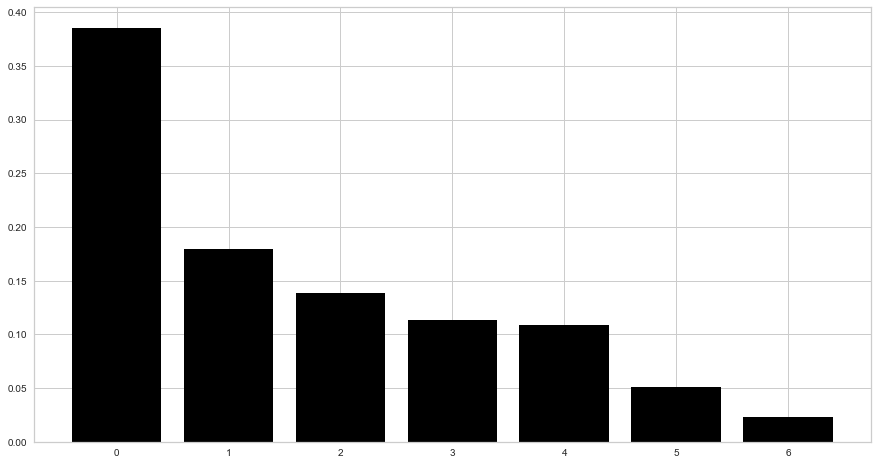

In [ ]:

pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color='black')

df_pca=pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

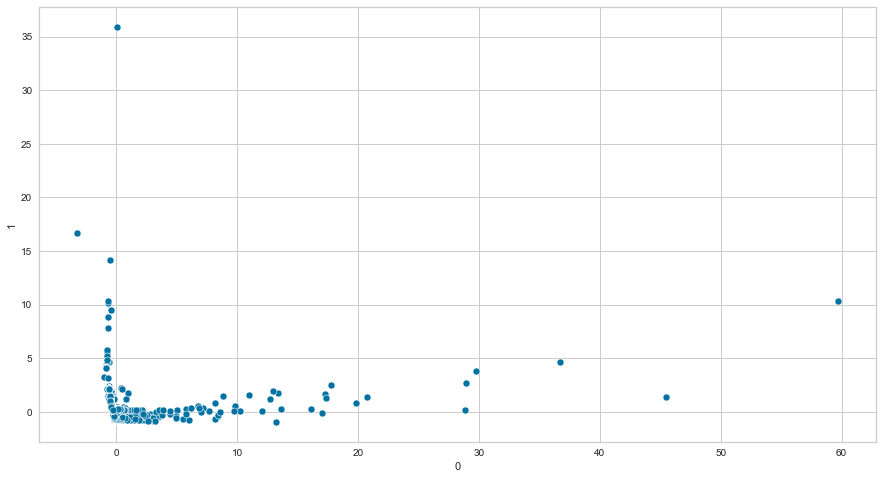

In [ ]:
sns.scatterplot(x=0 , y=1, data=df_pca)

## 4.2 Space study - UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

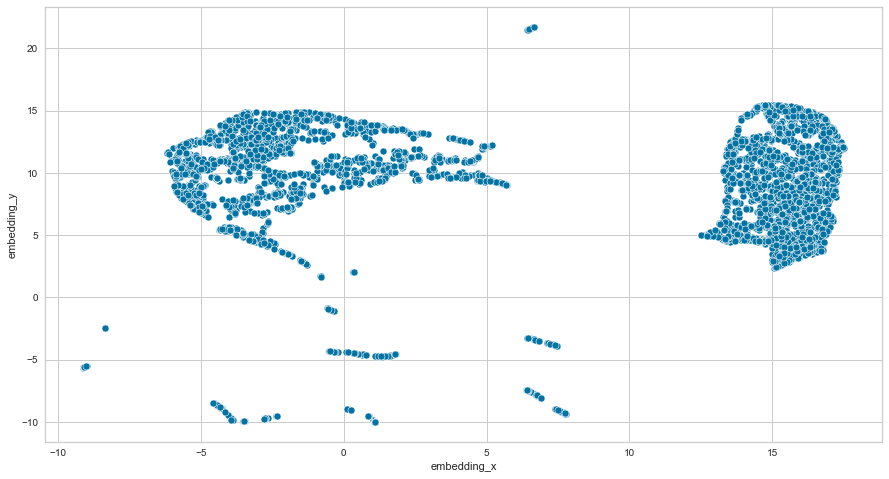

In [ ]:
reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x']=embedding[:,0]
df_pca['embedding_y']=embedding[:,1]

X2=X.merge(df_pca,left_index=True, right_index=True, how='left')

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=X2)

## 4.3 Space Study - t-SNE

p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

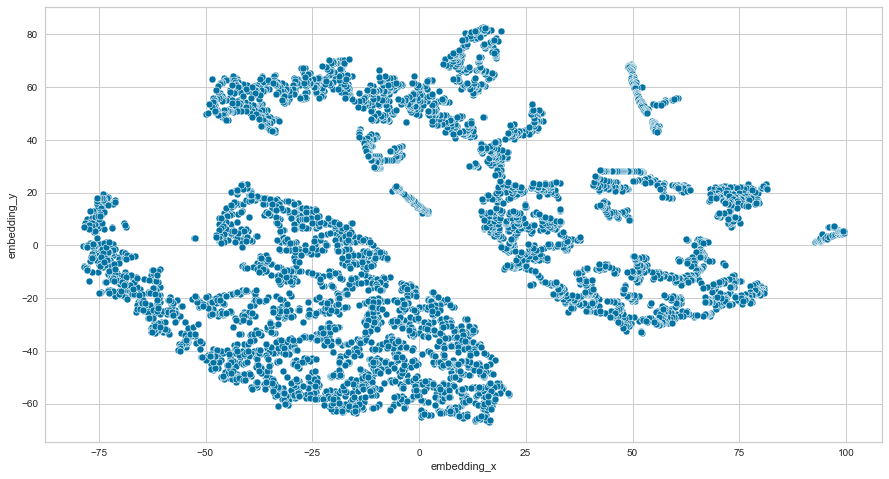

In [ ]:
reducer = TSNE( random_state=42)
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x']=embedding[:,0]
df_pca['embedding_y']=embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=df_pca)

## Space based Tree-Based Embedding

In [ ]:
# training dataset

X = df5.drop(['gross_revenue','customerid'],axis=1)
y = df5['gross_revenue']


# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state=42)

# model training

rf_model.fit( X, y )

#leaf 

df_leaf = pd.DataFrame(rf_model.apply(X))

p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

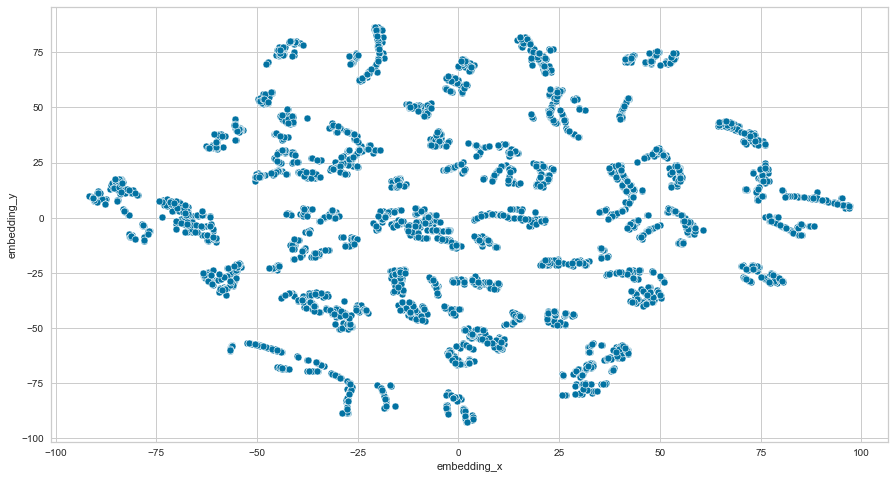

In [ ]:
reducer = TSNE( random_state=42)
embedding = reducer.fit_transform( df_leaf )

# embedding
df_leaf['embedding_x']=embedding[:,0]
df_leaf['embedding_y']=embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=df_leaf)

## 4.4 Bivariate analysis

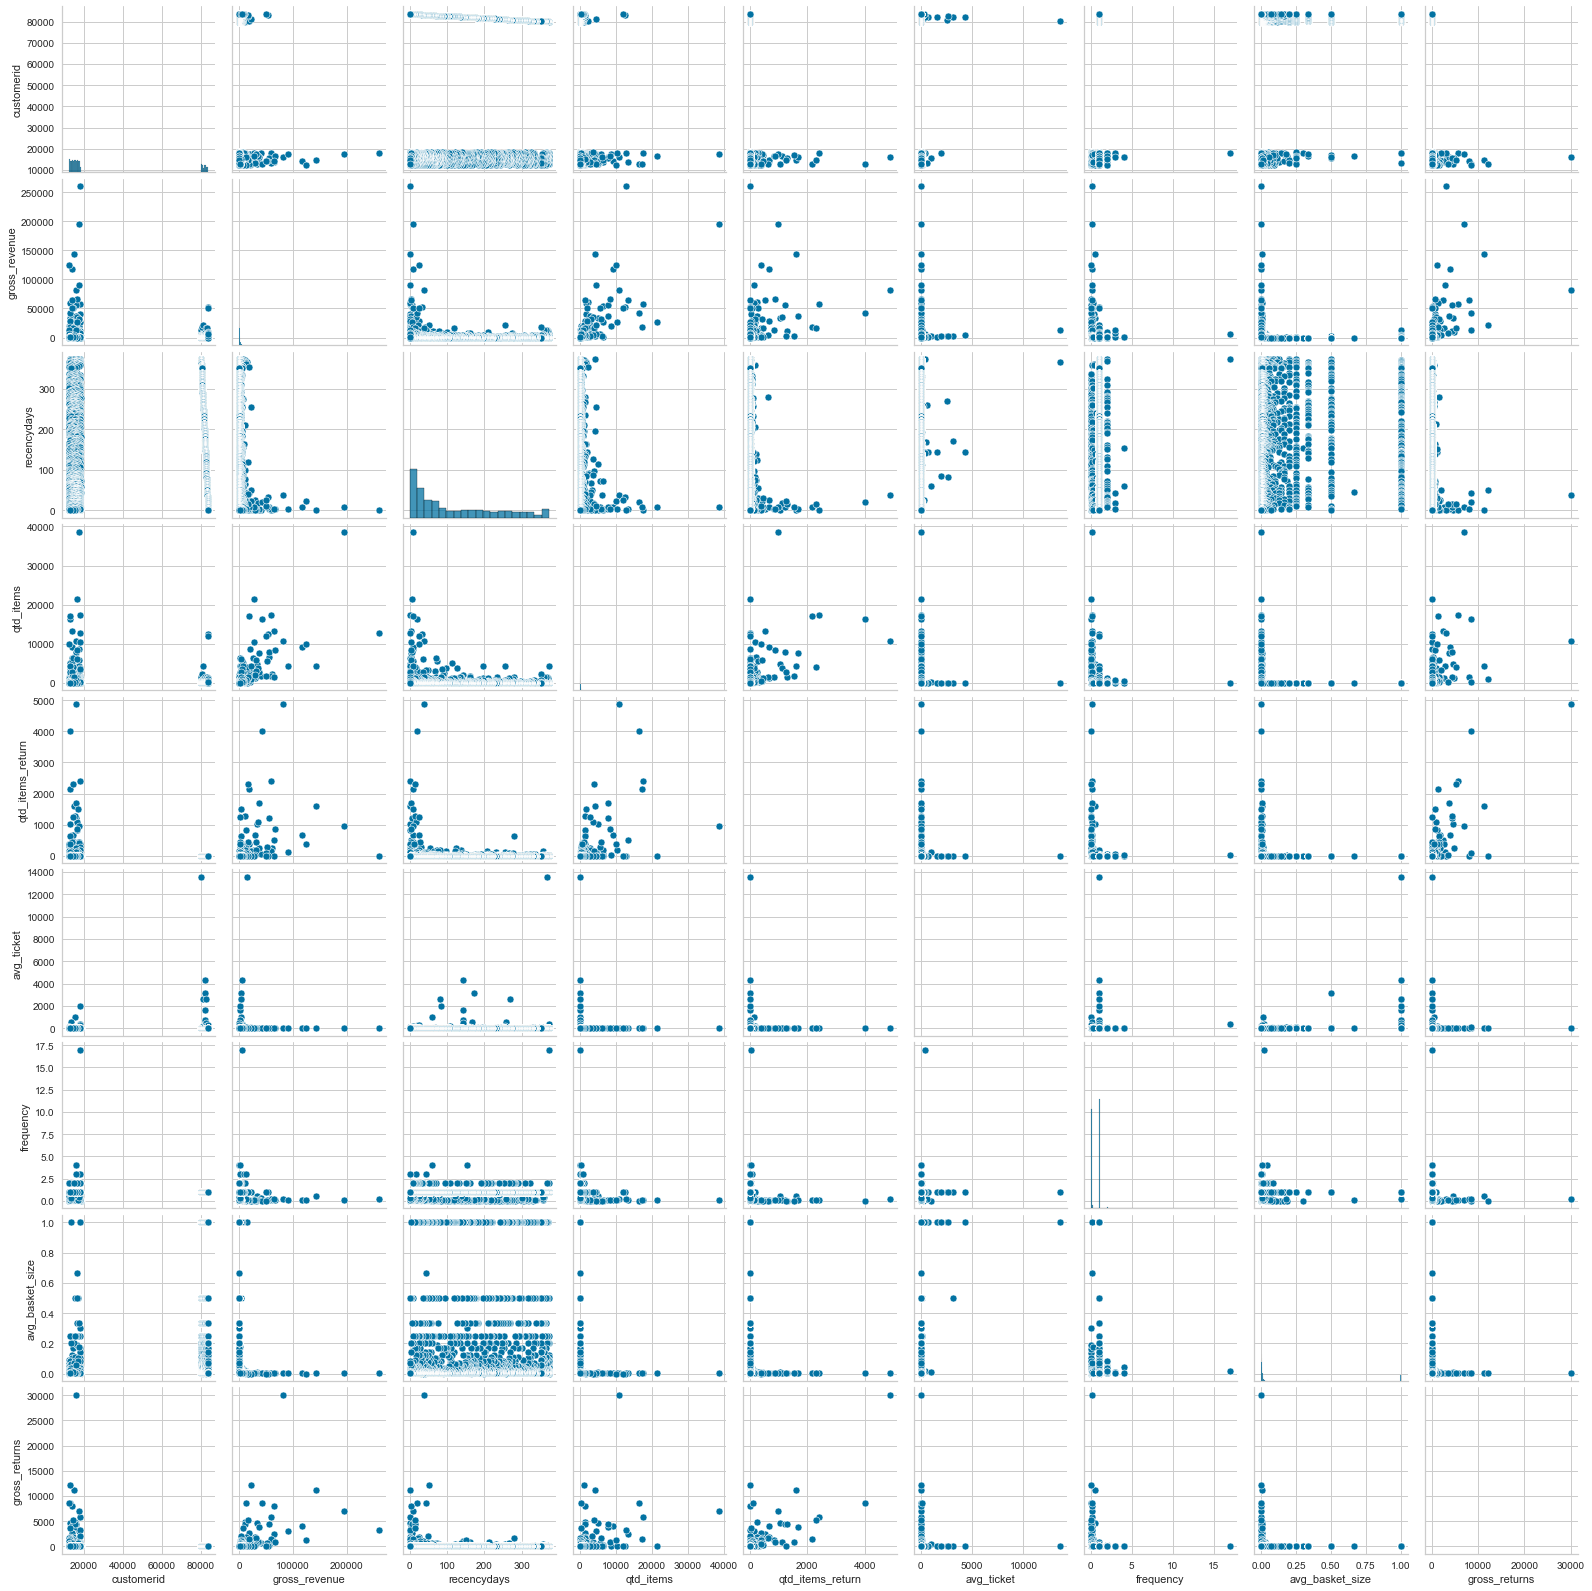

In [ ]:
sns.pairplot(df5)
plt.show()

# 8.0 Model training

## 8.1 K-Means

In [ ]:
# model definition
k=4
kmeans = c.KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)
labels = kmeans.labels_


## 8.2 Cluster Validation

In [ ]:
## WSS score
print(f"WSS {kmeans.inertia_}")
m.silhouette_score(X,labels,metric='euclidean')

WSS 34240897.52415071


0.9821240067239864

# 9.0 Cluster Analysis

In [ ]:
df9=df6.copy()
df9['cluster']=labels
df9.head(2)

,customerid,gross_revenue,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,gross_returns,cluster
0,17850,3.383944,0.997319,-0.371257,21.0,40.502289,1.000000,1.262198,24.42381,0
1,13047,1.851988,0.083110,0.209581,6.0,1.980876,0.001395,0.046709,37.72381,0


## 9.1 Visual Inspection

p:\Anaconda3\envs\automl\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


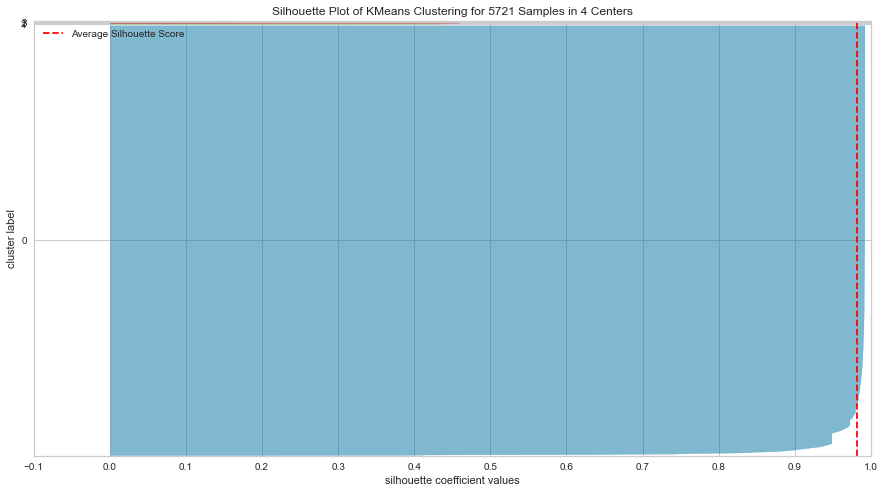

In [ ]:
visualizer = SilhouetteVisualizer( kmeans, init='k-means++', colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d plot

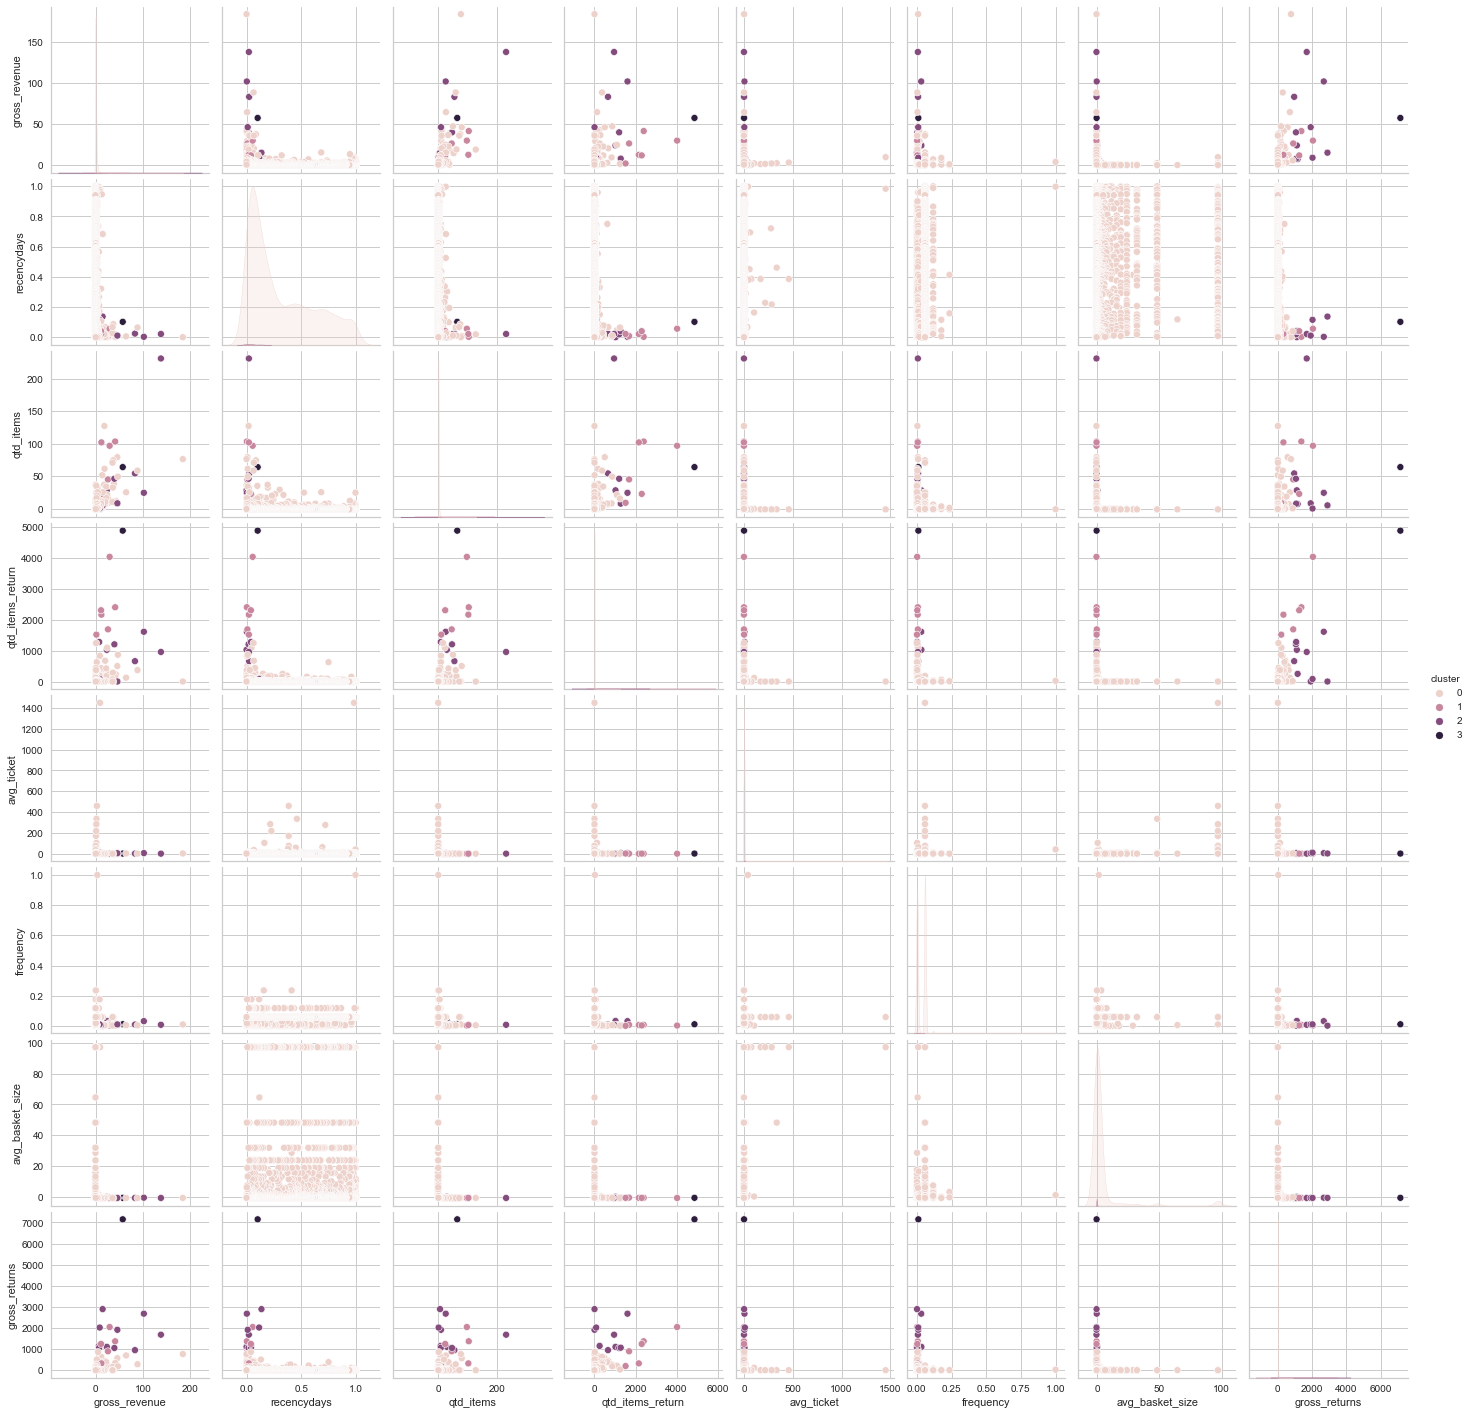

In [ ]:
df_viz = df9.drop(columns='customerid',axis=1)
sns.pairplot(df_viz, hue='cluster')

In [ ]:
#comeny

## 9.3 UMAP 

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

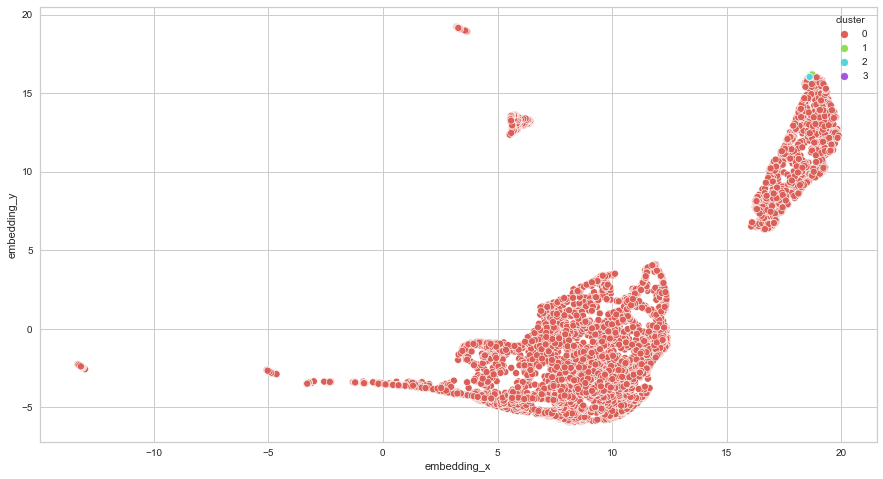

In [ ]:
reducer = umap.UMAP(n_neighbors=40, random_state=42)
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x']=embedding[:,0]
df_viz['embedding_y']=embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors= len(df_viz['cluster'].unique())),
                data=df_viz)

## 9.4 Cluster Profile

In [ ]:
# Number of customers
#   
df_cluster=df9.groupby(['cluster']).agg({"customerid":"count",
"profit":"mean", "recencydays":"mean" , "items_kept":"mean", "frequency":"mean"})

df_cluster

,customerid,profit,recencydays,items_kept,frequency
cluster,,,,,
0,6487,0.597874,0.330200,0.548822,0.035231
1,22,62.140142,0.027785,72.845512,0.014537


### Cluster 0: - Low Value, Low Frequency, High Recency

### Cluster 1: - Extremely high values, bought every 3 days

### Cluster 2: - High value, but buys at a low frequency and weekly rate

### Cluster 3: - Medium value, Medium frequency, Medium recency


# 10.0 EDA Cluster

## 10.1 Hypoteses Mindmap

In [ ]:
1. Phenom
2. Entity (Customer, Location)
3. Entity Characteristics

## 10.2 Business Hypoteses

## 10.3 Hypoteses priorization

## 10.4 Hypoteses Validation

## 10.5 Board of Answers

Dores do negócio e decisões que vc tem dificuldade de tomar